In [60]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
%autoreload 2

import pandas as pd 
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from config import COLUMN_MAP, TREATMENT_COLS, COVARIATES, OUTCOME_VARS
import io
import math
from clean import load_data, clean_data, visualize_data

## Load, Clean, Visualize DF

/Users/danielfrees/Desktop/finlitCausal/data/clean.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat_hs)
/Users/danielfrees/Desktop/finlitCausal/data/clean.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat_hs)
/Users/danielfrees/Desktop/finlitCausal/data/clean.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

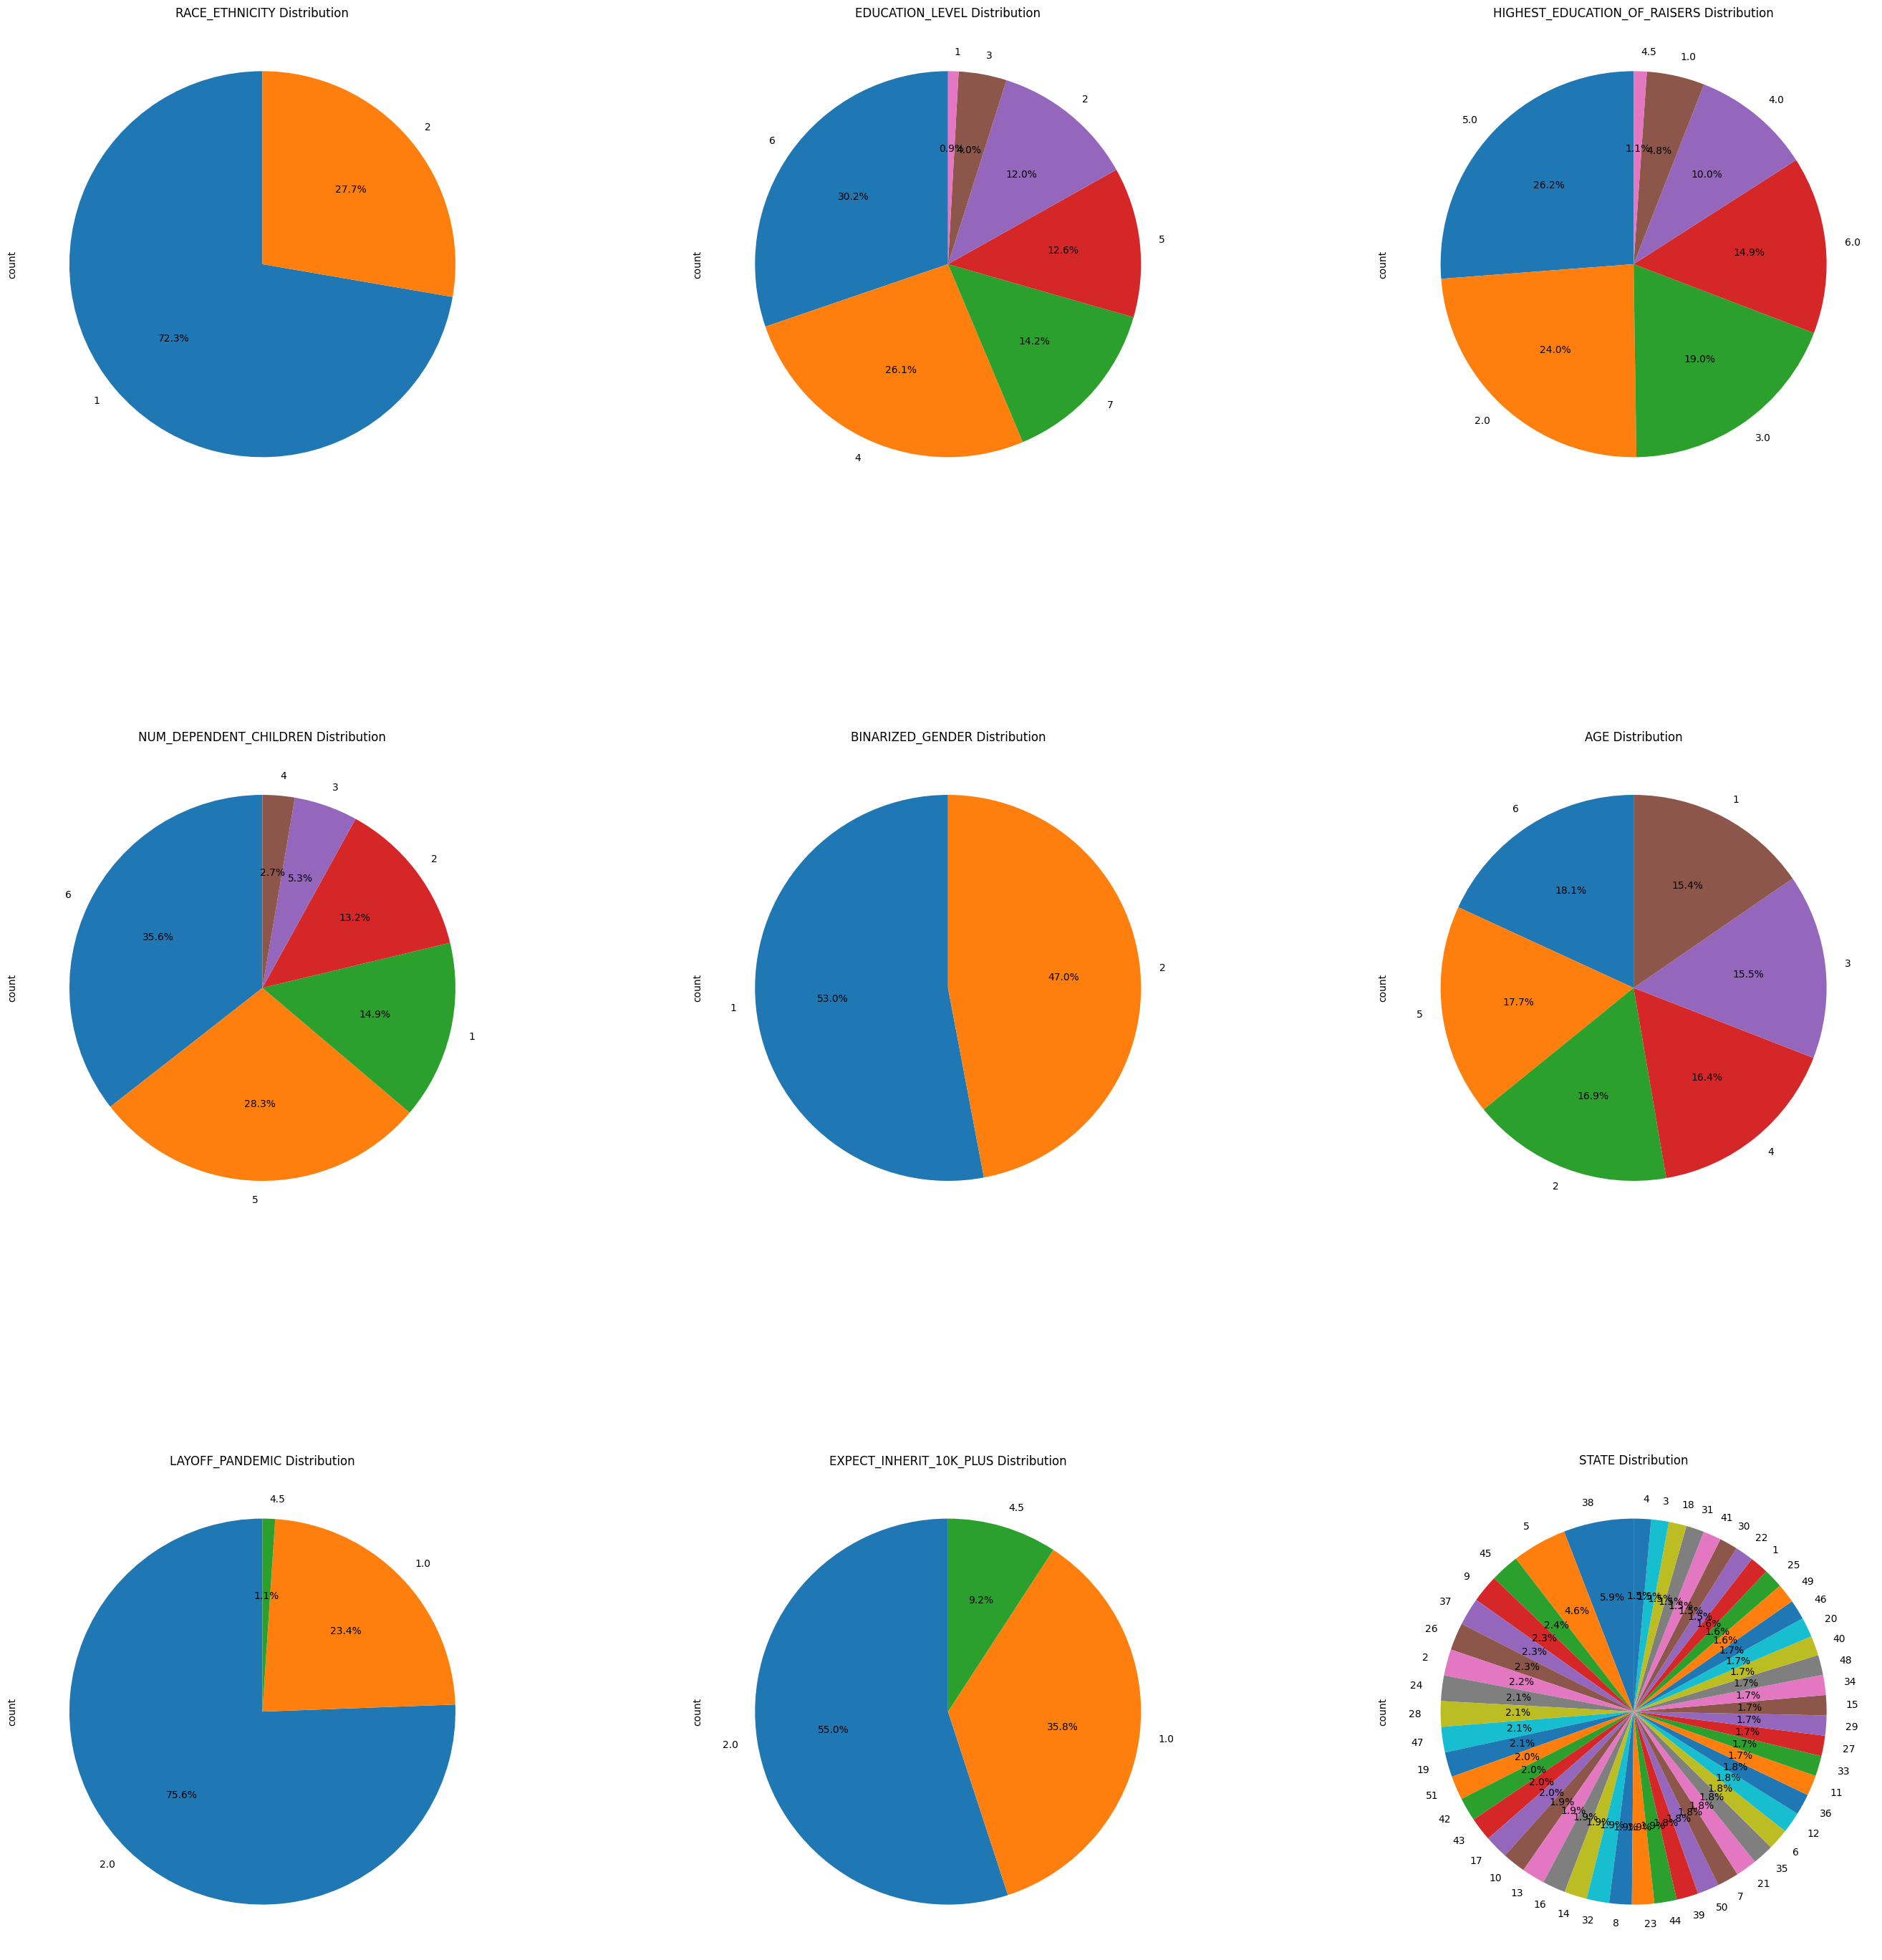

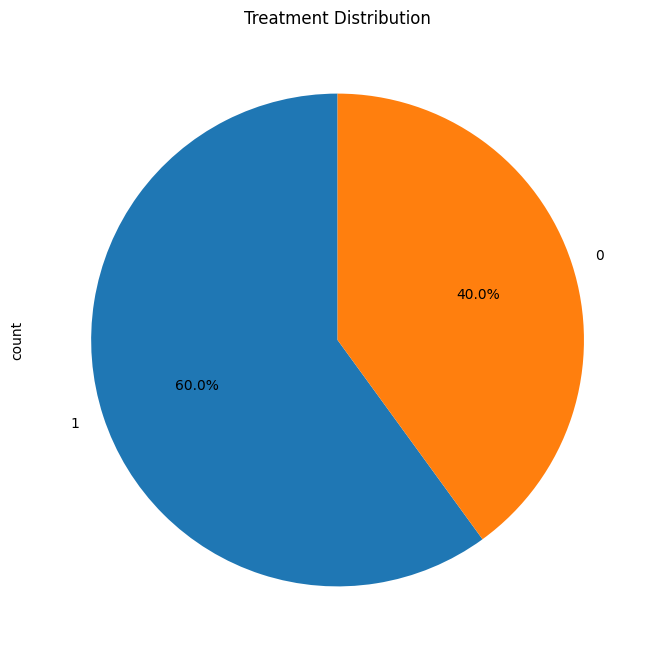

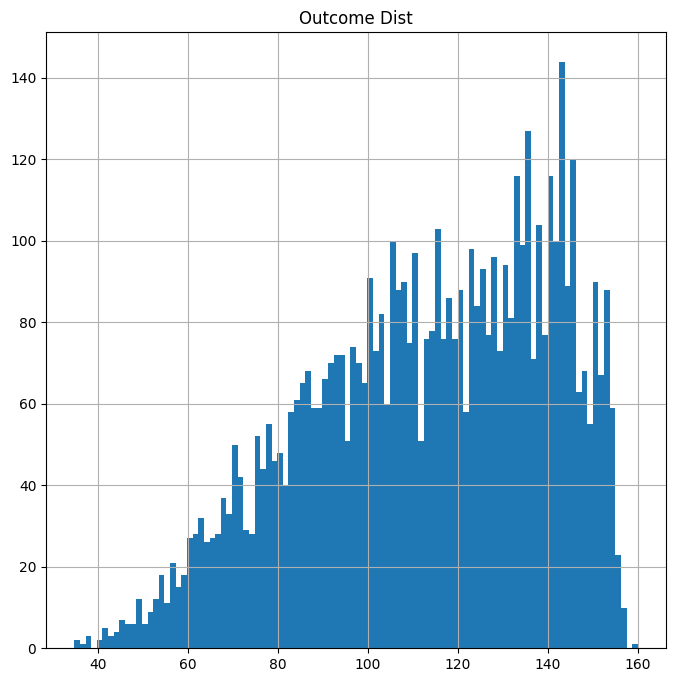

/Users/danielfrees/Desktop/finlitCausal/data/clean.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat_hs)
/Users/danielfrees/Desktop/finlitCausal/data/clean.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat_hs)
/Users/danielfrees/Desktop/finlitCausal/data/clean.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

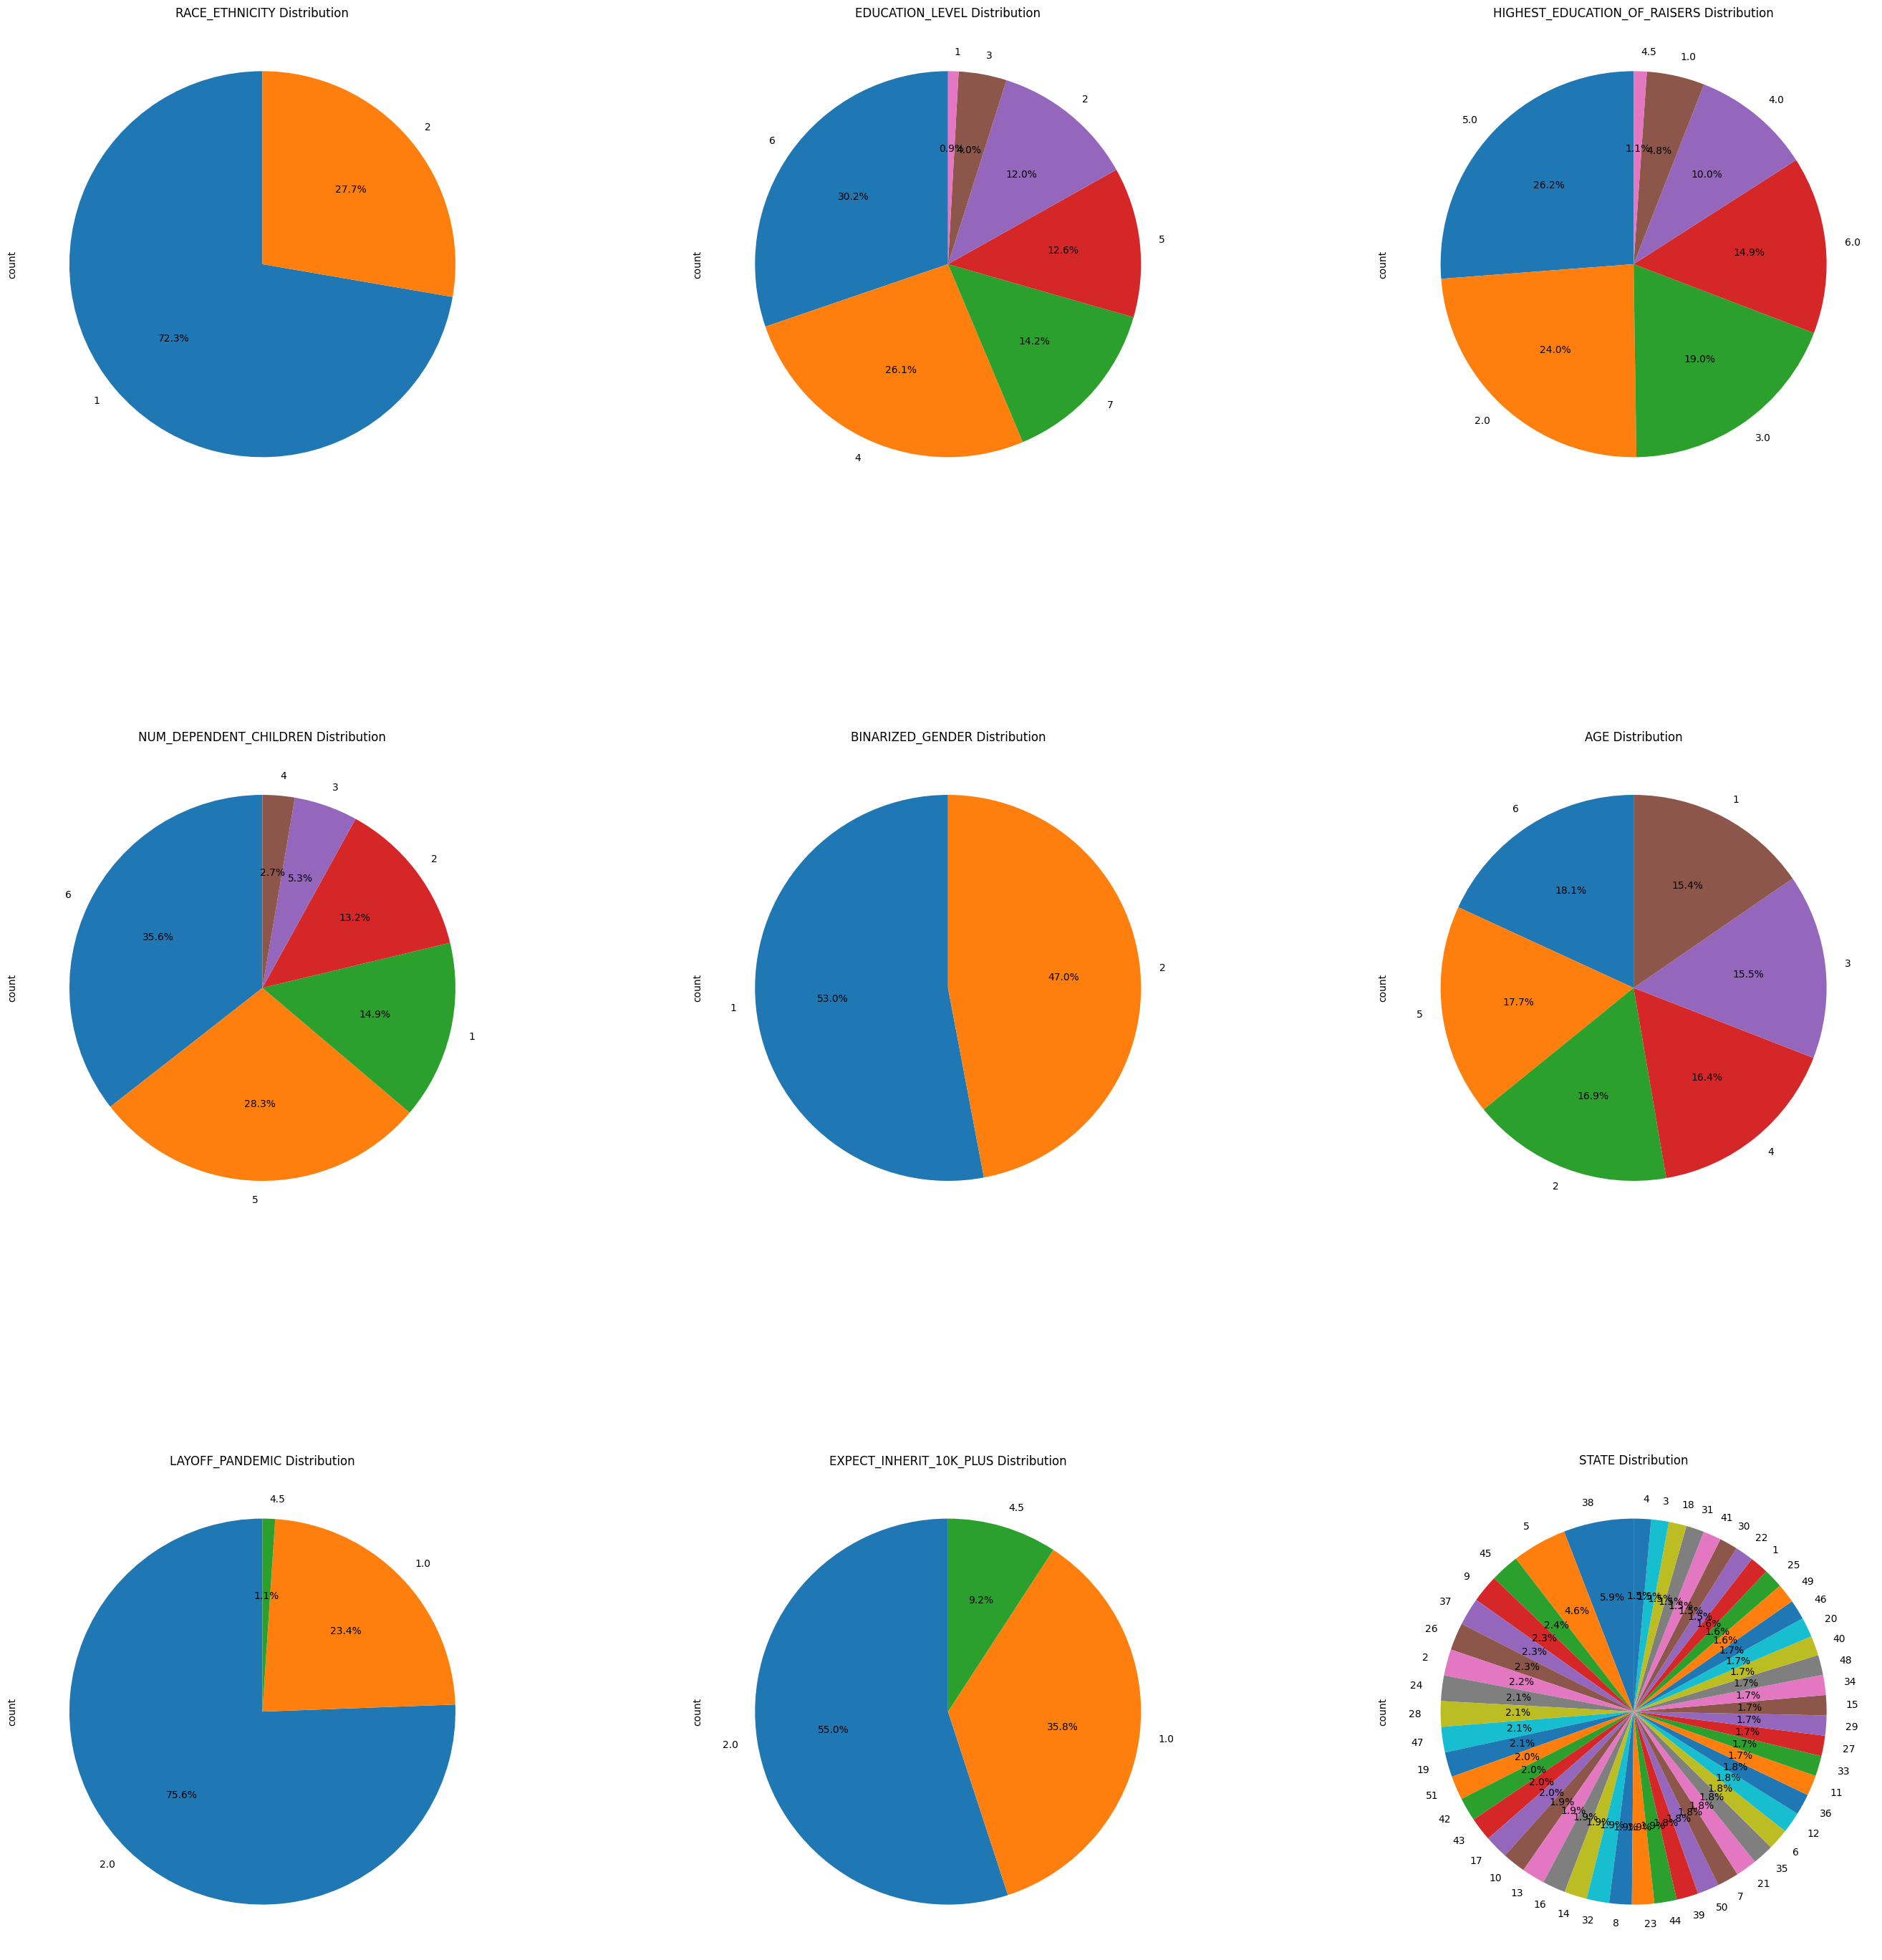

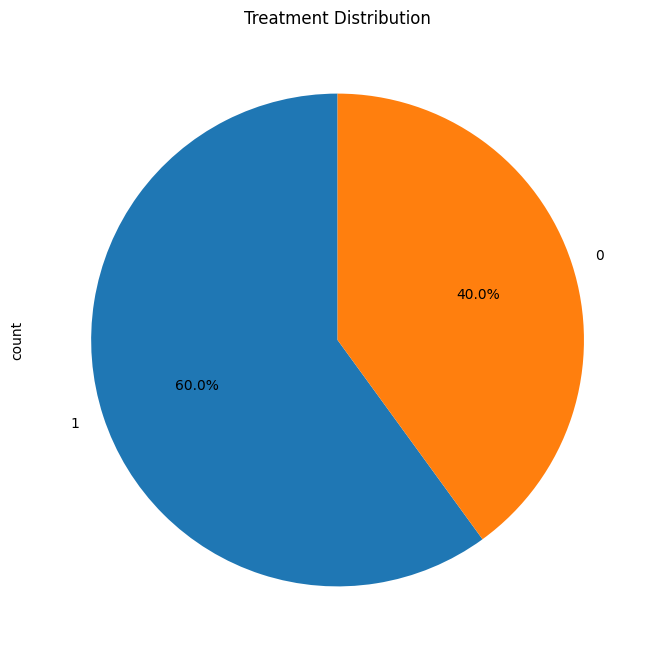

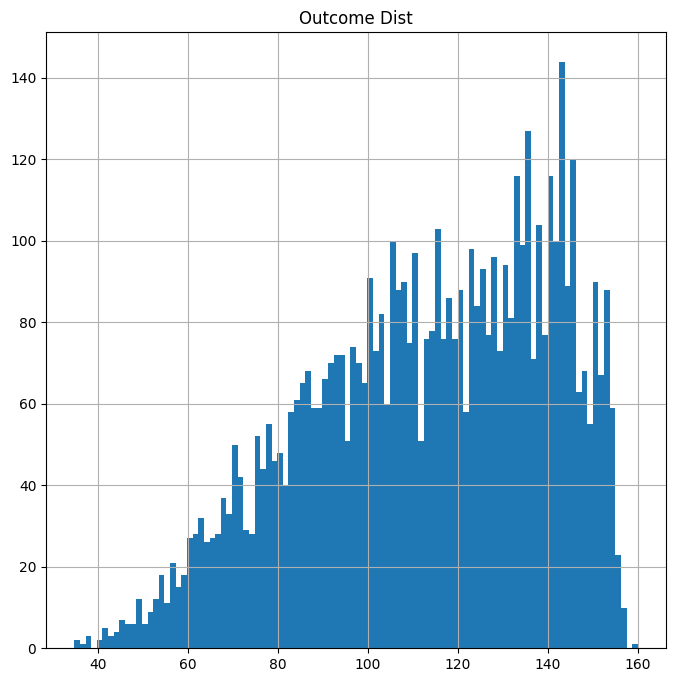

/Users/danielfrees/Desktop/finlitCausal/data/clean.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat_hs)
/Users/danielfrees/Desktop/finlitCausal/data/clean.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat_hs)
/Users/danielfrees/Desktop/finlitCausal/data/clean.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

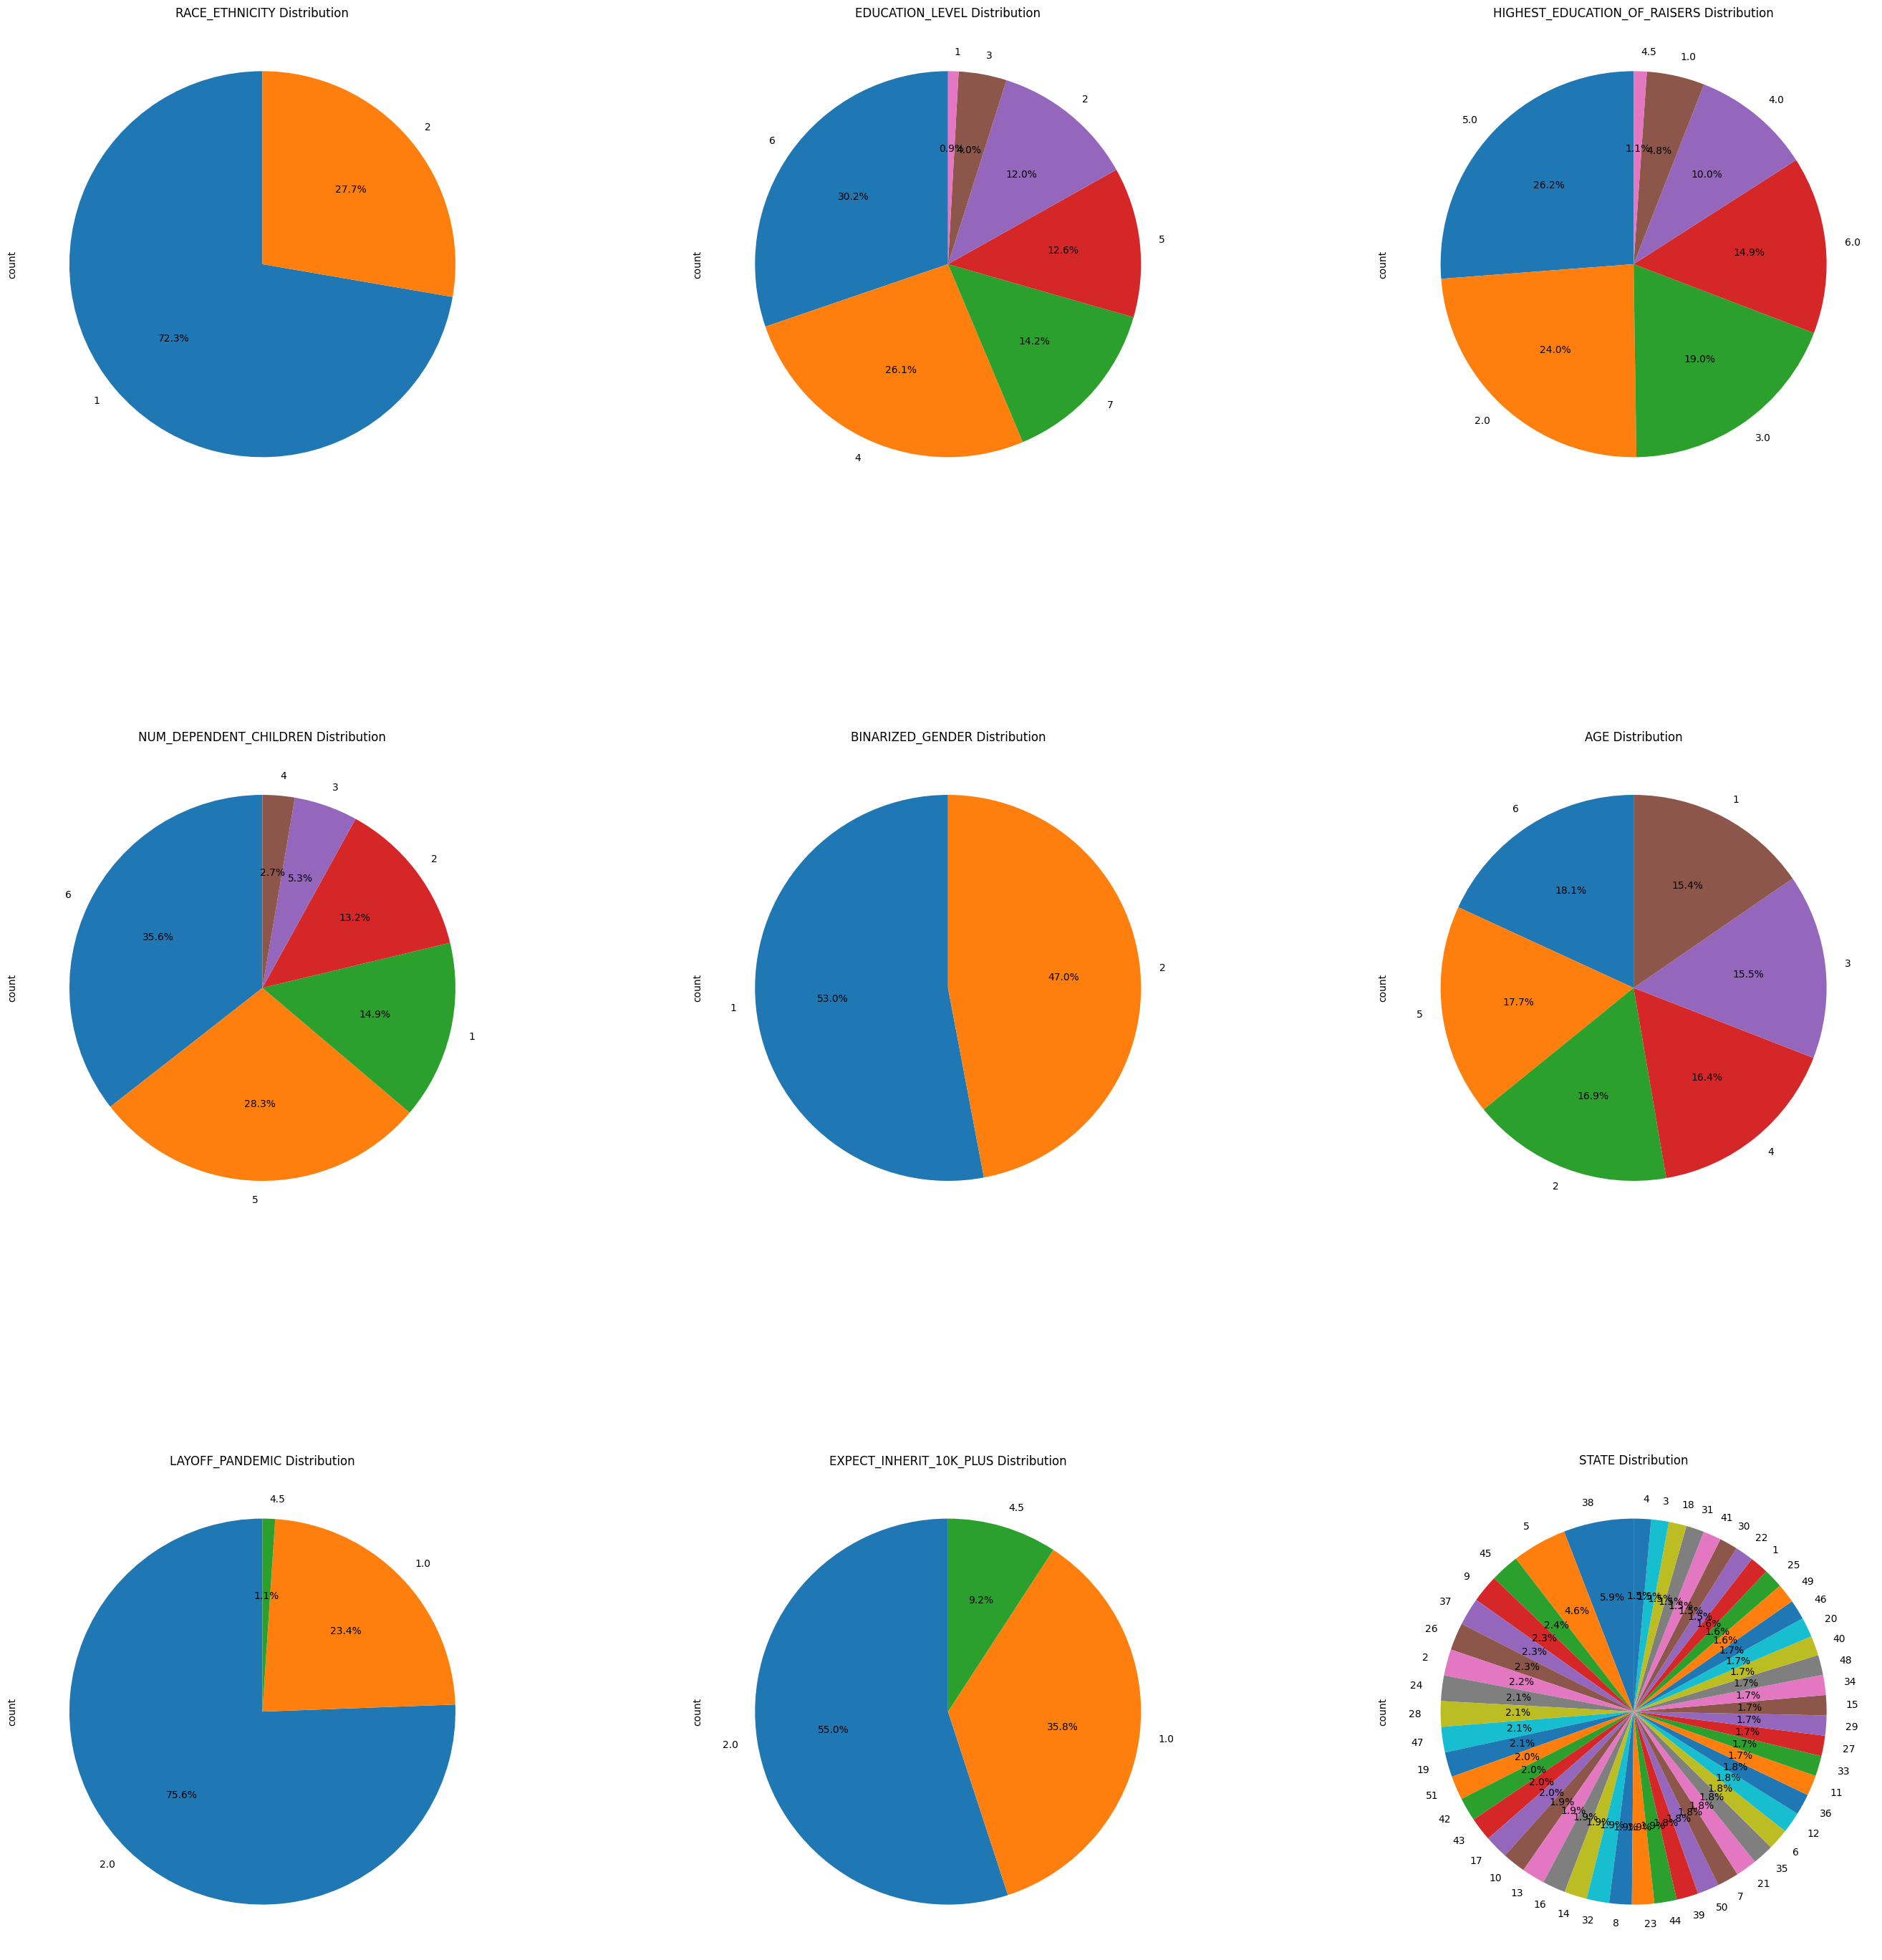

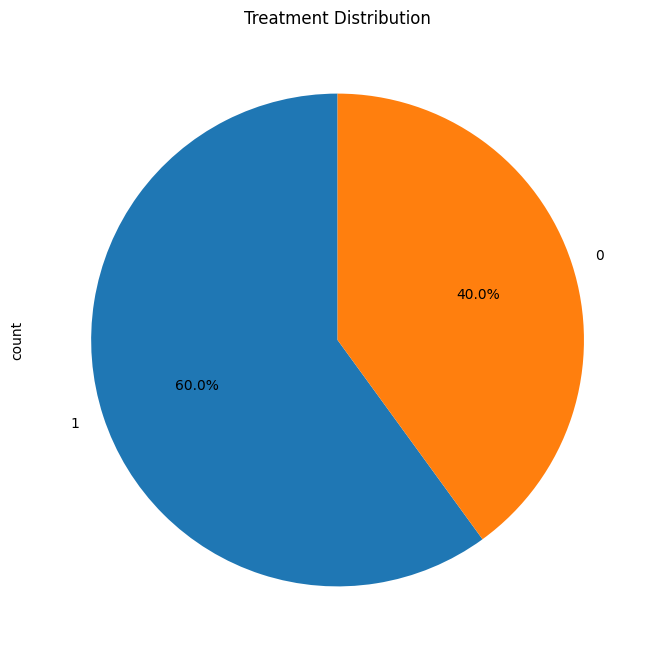

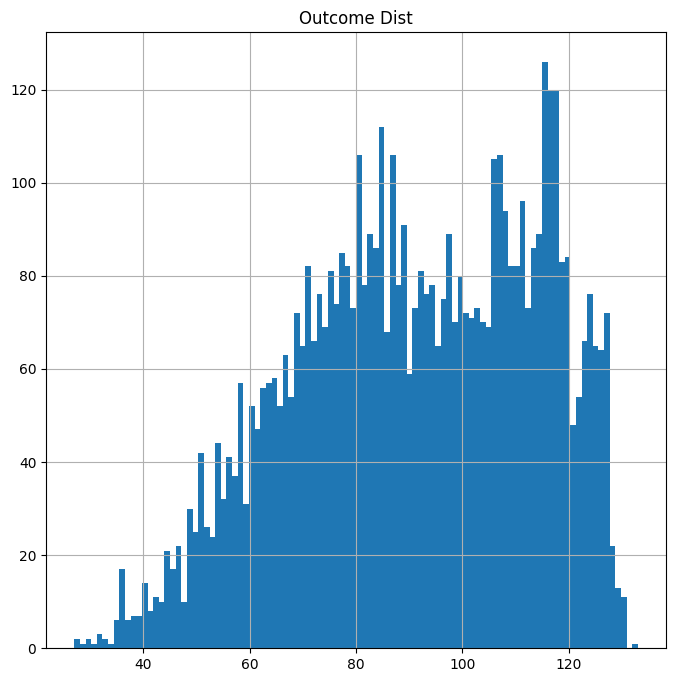

/Users/danielfrees/Desktop/finlitCausal/data/clean.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat_hs)
/Users/danielfrees/Desktop/finlitCausal/data/clean.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z'] = df.loc[:, 'FIN_ED_HS'].map(binarize_treat_hs)
/Users/danielfrees/Desktop/finlitCausal/data/clean.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

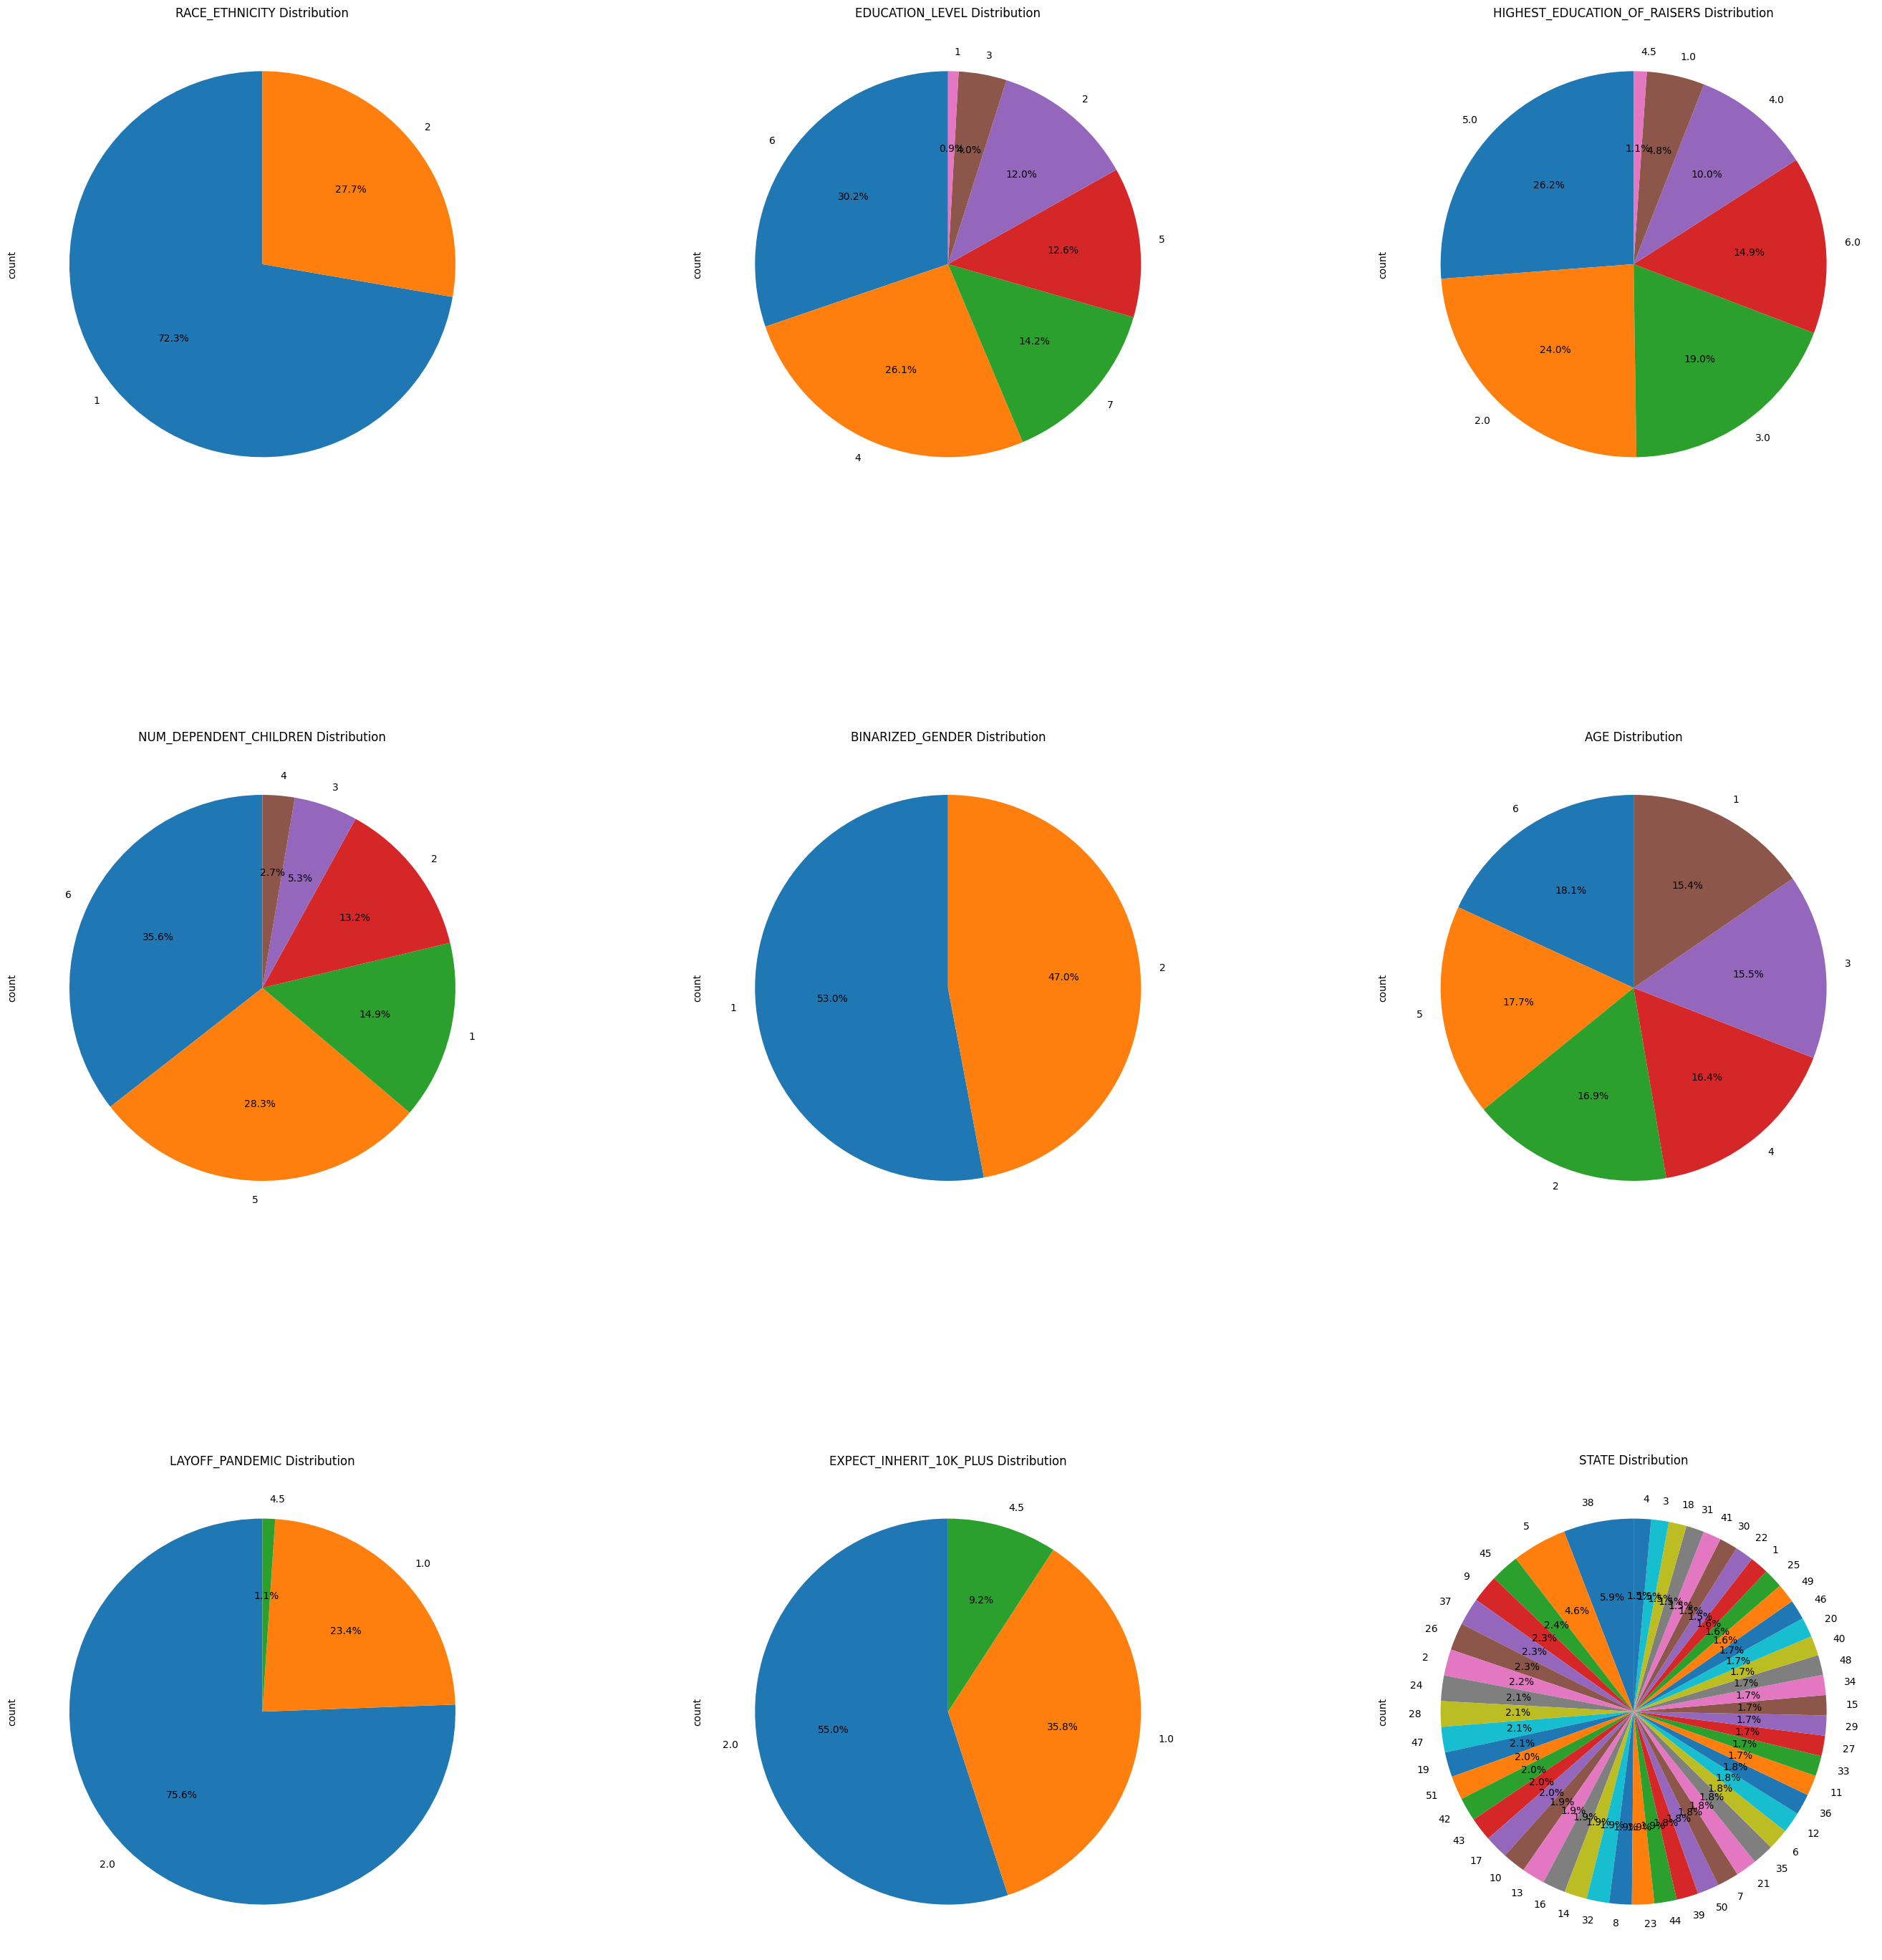

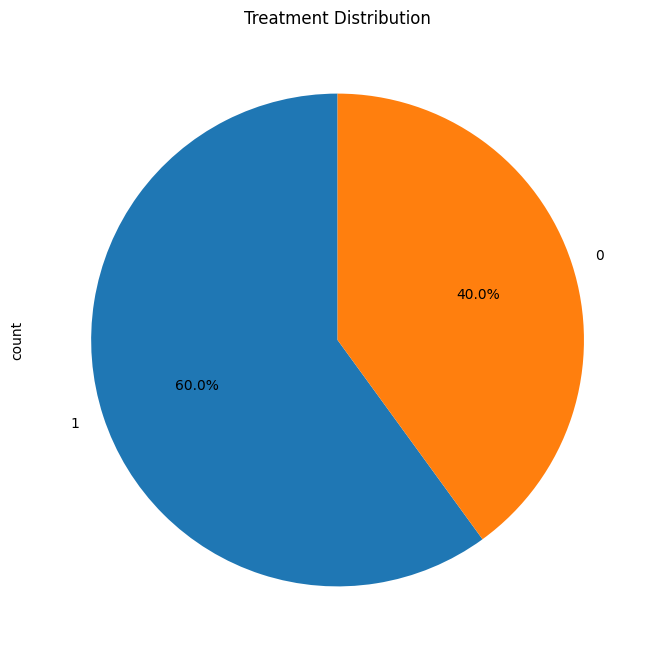

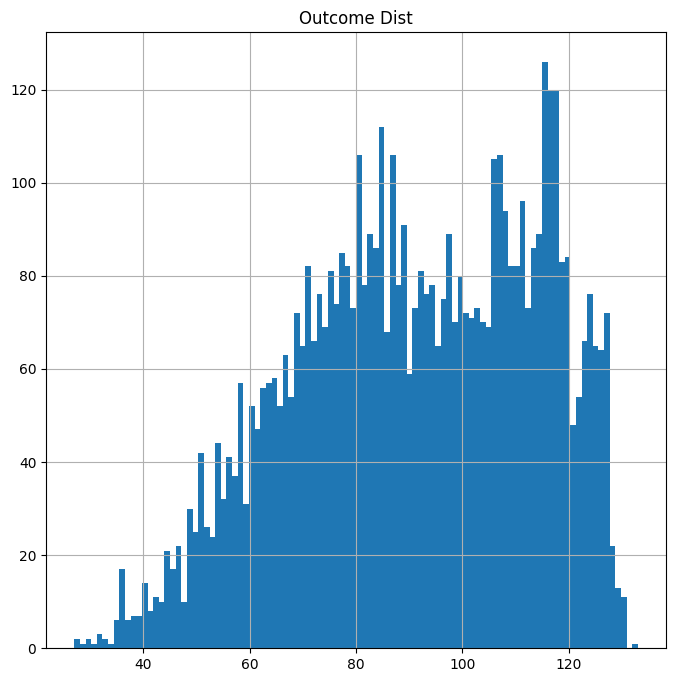

In [62]:
scale = [False, True]
type_ed = ['hs', 'all']
df = None
for sc in scale:
    for ed in type_ed:
        df = load_data()
        df = clean_data(df, scale_vals=sc)
        df['Z'].value_counts()
        visualize_data(df)
        df.to_csv(f'fin_lit_data_treat={ed}_scale={str(sc)}.csv', index=False)

In [63]:
pd.isna(df.iloc[26]['ALWAYS_PAY_CR_FULL_12MO'])

False

<Axes: ylabel='count'>

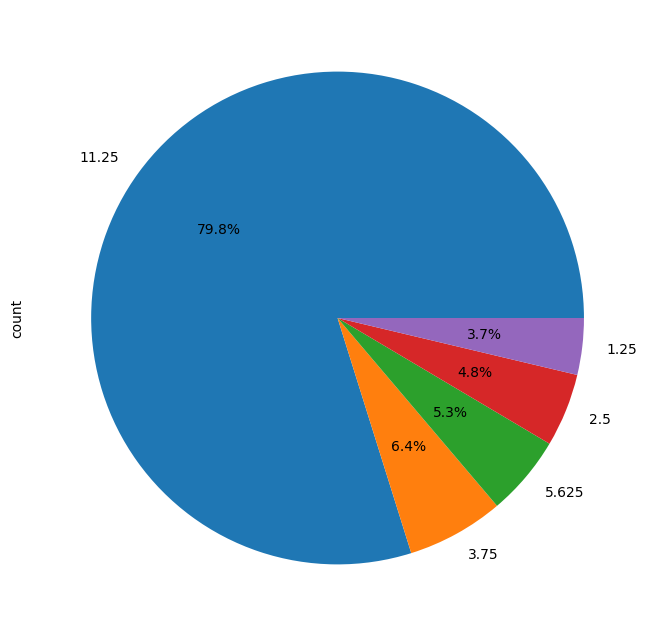

In [64]:
plt.rcParams['figure.figsize'] =[8,8]
df['USED_PAYDAY_LOAN'].value_counts().plot.pie(autopct='%1.1f%%',)